In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os

## 1.1. Utils

In [5]:
def read_img(img_path):
  """
    Read grayscale image
    Inputs:
      img_path: str: image path
    Returns:
      img: cv2 image
  """
  return cv2.imread(img_path, 0)

def show_img(img):
  plt.figure(figsize=(12, 9))
  plt.imshow(img, cmap='gray')

def show_res(before_img, after_img, title_1="Before", title_2="After"):
  """
    Show the original image and the corresponding smooth image
    Inputs:
      before_img: cv2: image before smoothing
      after_img: cv2: corresponding smoothed image
    Return:
      None
  """
  plt.figure(figsize=(12, 9))
  plt.subplot(1, 2, 1)
  plt.imshow(before_img, cmap='gray')
  plt.title(title_1)

  plt.subplot(1, 2, 2)
  plt.imshow(after_img, cmap='gray')
  plt.title(title_2)
  plt.show()

## 1.2. Image Filters

In [2]:
def padding_img(img, filter_size=3, padding_mode='mirror'):
  """
    The surrogate function for the filter functions.
    The goal of the function: padding the image such that when applying the kernel with the size of filter_size, the padded image will be the same size as the original image.
    WARNING: Do not use the exterior functions from available libraries such as OpenCV, scikit-image, etc. Just do from scratch using function from the numpy library or functions in pure Python.
    Inputs:
      img: cv2 image: original image
      filter_size: int: size of square filter
      padding_mode: str: 'zero'| 'mirror' | 'replicate'
    Return:
      padded_img: cv2 image: the padding image
  """
  assert filter_size % 2 == 1, "Filter size must be odd number"
  assert filter_size <= min(img.shape), "Filter size must not be too large"
  assert padding_mode in ["zero", "mirror", "replicate"], "Invalid padding mode"
  s = filter_size // 2
  if padding_mode == "replicate":
    pad_top = np.tile(img[0, :], (s, 1))
    pad_bot = np.tile(img[-1, :], (s, 1))
    img = np.concatenate([pad_top, img, pad_bot], axis=0)
    pad_left = np.tile(img[:, 0], (s, 1)).T
    pad_right = np.tile(img[:, -1], (s, 1)).T
    img = np.concatenate([pad_left, img, pad_right], axis=1)
    return img
  elif padding_mode == "zero":
    pad_top = pad_bot = np.zeros((s, img.shape[1]))
    img = np.concatenate([pad_top, img, pad_bot], axis=0)
    pad_left = pad_right = np.zeros((img.shape[0], s))
    img = np.concatenate([pad_left, img, pad_right], axis=1)
    return img
  else:
    pad_top = img[s:0:-1, :]
    pad_bot = img[-2:-2 - s:-1, :]
    img = np.concatenate([pad_top, img, pad_bot], axis=0)
    pad_left = img[:, s:0:-1]
    pad_right = img[:, -2:-2-s:-1]
    img = np.concatenate([pad_left, img, pad_right], axis=1)
    return img


def mean_filter(img, filter_size=3, padding_mode='mirror'):
  """
  Smoothing image with mean square filter with the size of filter_size.
  WARNING: Do not use the exterior functions from available libraries such as OpenCV, scikit-image, etc. Just do from scratch using function from the numpy library or functions in pure Python.
  Inputs:
    img: cv2 image: original image
    filter_size: int: size of square filter,
    padding_mode: str: 'zero'| 'mirror' | 'replicate'
  Return:
    smoothed_img: cv2 image: the smoothed image with mean filter.
  """

  convolve = np.zeros((img.shape))
  img = padding_img(img, filter_size, padding_mode)
  filter = np.ones((filter_size, filter_size)) / (filter_size**2)
  s = filter_size // 2
  x, y = img.shape
  for v in range(s, x - s):
    for h in range(s, y - s):  #
        area = img[(v - s):(v + s + 1), (h - s): (h + s + 1)]
        convolve[v - s, h - s] = np.sum(np.multiply(filter, area))
  return convolve


def median_filter(img, filter_size=3, padding_mode='mirror'):
  """
  Smoothing image with median square filter with the size of filter_size.
  WARNING: Do not use the exterior functions from available libraries such as OpenCV, scikit-image, etc. Just do from scratch using function from the numpy library or functions in pure Python.
  Inputs:
    img: cv2 image: original image
    filter_size: int: size of square filter
    padding_mode: str: 'zero'| 'mirror' | 'replicate'
  Return:
    smoothed_img: cv2 image: the smoothed image with median filter.
  """
  median = np.zeros((img.shape))
  img = padding_img(img, filter_size, padding_mode)
  s = filter_size // 2
  x, y = img.shape
  for v in range(s, x - s):
    for h in range(s, y - s):
        area = img[(v - s):(v + s + 1), (h - s): (h + s + 1)]
        median[v - s, h - s] = np.median(area)
  return median

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### You need upload the supplied images before running the following code cells

In [5]:
noise_img_path = "/content/drive/MyDrive/Colab/noise.png"

In [6]:
noise_img = read_img(noise_img_path)

mean_blur = mean_filter(noise_img)
median_blur = median_filter(noise_img)

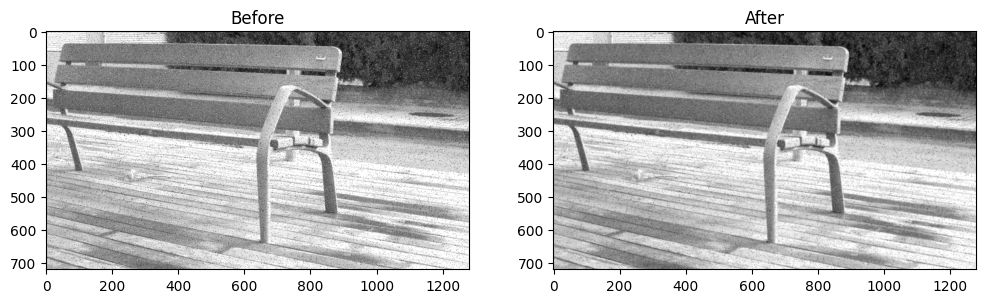

In [7]:
show_res(noise_img, mean_blur)

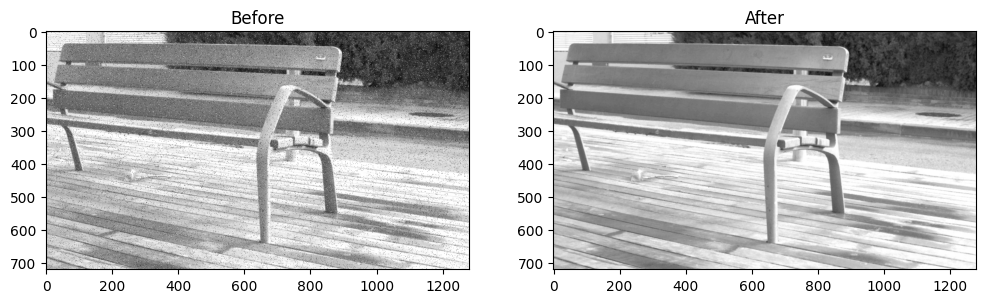

In [8]:
show_res(noise_img, median_blur)

## 1.3. Metrics

In [16]:
from skimage.metrics import structural_similarity as compare_ssim

* To evaluate the similarity of 2 images using structural_similarity: compare_ssim(image_1, image_2)
* Document of structural_similarity: [link](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity).


In [10]:
clean_img_path = "/content/drive/MyDrive/Colab/ori_img.png"
noise_img_path = "/content/drive/MyDrive/Colab/noise.png"

In [11]:
def psnr(gt_img, smooth_img):
  """
    Calculate the PSNR metric
    Inputs:
      gt_img: cv2 image: groundtruth imageDrag here, paste an image or file, or


      smooth_img: cv2 image: smoothed image
    Outputs:
      psnr_score: PSNR score
  """
  try:
    gt_img = np.array(gt_img)
    smooth_img = np.array(smooth_img)
  except Exception:
    raise ValueError("Input must be 2D array like format")

  return 20 * np.log10(np.max(gt_img)/np.sqrt(mse(gt_img, smooth_img)))


def mse(gt_img, smooth_img):
  """
  Calculate the Mean Square Error metric
  Inputs:
    gt_img: cv2 image: groundtruth image
    smooth_img: cv2 image: smoothed image
  Outputs:
    mse_score: MSE score
  """
  try:
    gt_img = np.array(gt_img)
    smooth_img = np.array(smooth_img)
  except Exception:
    raise ValueError("Input must be 2D array like format")

  return np.mean(np.power((gt_img - smooth_img), 2))


PSNR between noise image and clean image: 41.137976602367075
MSE between noise image and clean image: 5.0036013454861115
SSIM between noise image and clean image: 0.362664911563029
-------------------------------------------------------------------------
PSNR between mean filtered image and clean image: 26.263183884698236
MSE between mean filtered image and clean image: 153.73118413226595
SSIM between mean filtered image and clean image: 0.6363219640842767
-------------------------------------------------------------------------
PSNR between median filtered image and clean image: 36.91360687919537
MSE between median filtered image and clean image: 13.234869791666666
SSIM between median filtered image and clean image: 0.9628636170478749


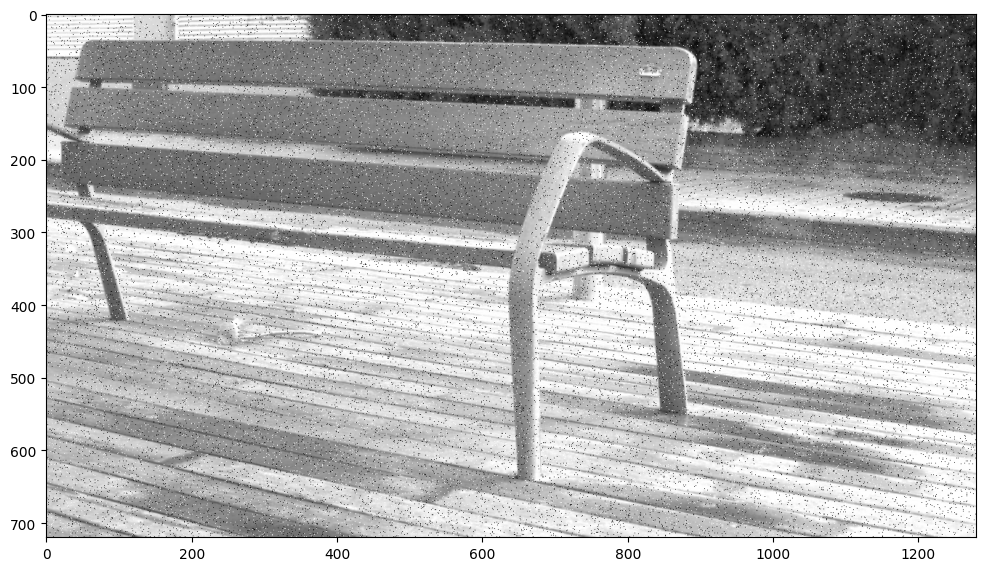

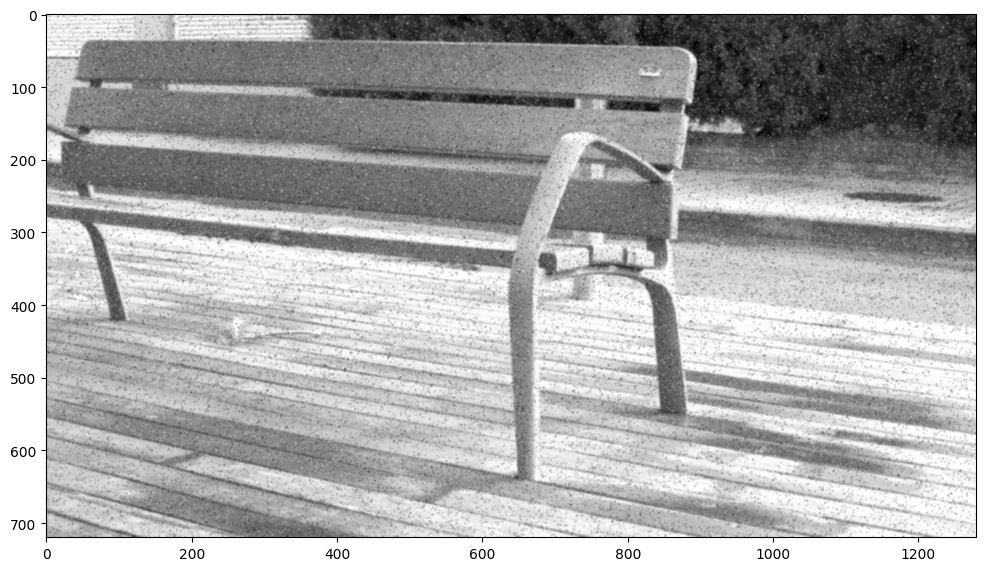

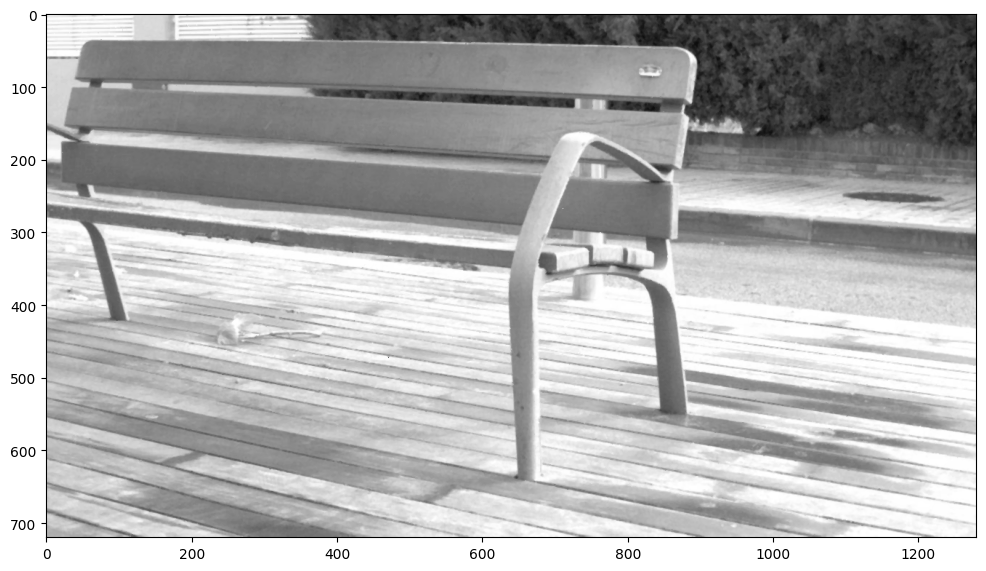

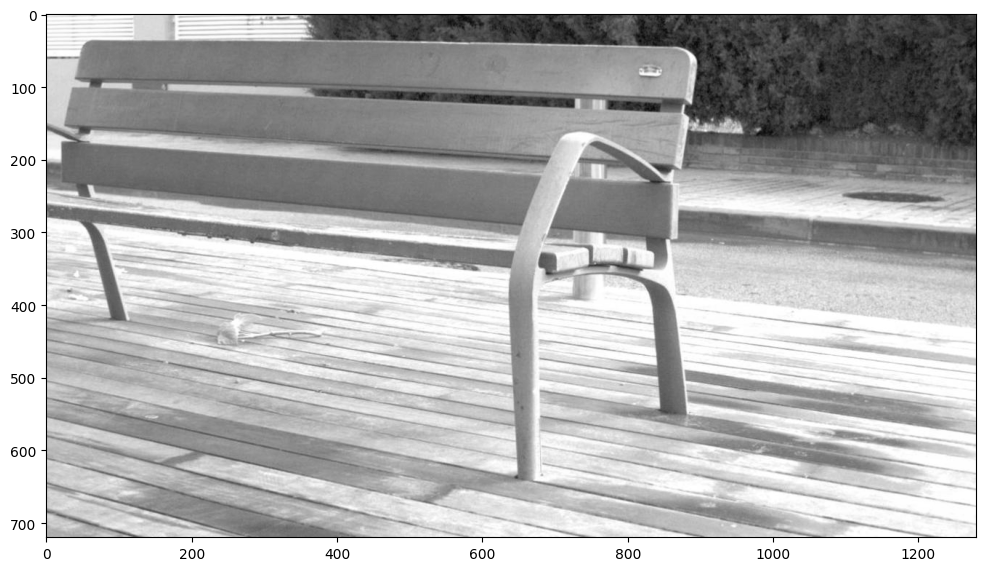

In [12]:
noise_img = read_img(noise_img_path)
clean_img = read_img(clean_img_path)
show_img(noise_img)
show_img(mean_blur)
show_img(median_blur)
show_img(clean_img)
print("PSNR between noise image and clean image:", psnr(clean_img, noise_img))
print("MSE between noise image and clean image:", mse(clean_img, noise_img))
print("SSIM between noise image and clean image:", compare_ssim(clean_img, noise_img, data_range=clean_img.max() - clean_img.min()))
print("-------------------------------------------------------------------------")
print("PSNR between mean filtered image and clean image:", psnr(clean_img, mean_blur))
print("MSE between mean filtered image and clean image:", mse(clean_img, mean_blur))
print("SSIM between mean filtered image and clean image:", compare_ssim(clean_img, mean_blur, data_range=clean_img.max() - clean_img.min()))
print("-------------------------------------------------------------------------")
print("PSNR between median filtered image and clean image:", psnr(clean_img, median_blur))
print("MSE between median filtered image and clean image:", mse(clean_img, median_blur))
print("SSIM between median filtered image and clean image:", compare_ssim(clean_img, median_blur, data_range=clean_img.max() - clean_img.min()))






In [13]:
def optimize_params(noise_img, gt_img, smooth_fn):
  """
    Find the best value of parameters filter_size, padding_mode
    Inputs:
      noise_img: cv2 image: noise image
      gt_img: cv2 image: no noise image
      smooth_fn: the smooth function
    Outputs:
      best_filter_size
      best_padding_mode
  """
  try:
    noise_img = np.array(noise_img)
    gt_img = np.array(gt_img)
  except:
    print("Invalid input")
    return
  assert noise_img.shape[0] == gt_img.shape[0] and noise_img.shape[1] == gt_img.shape[1], "Noise image and Ground truth image must have same size"
  max_ssim = 0
  best_filter_size = 1
  best_padding_mode = "zero"
  for filter_size in range(1, 11, 2):
    for padding_mode in ['zero', 'mirror', 'replicate']:
      new_img = smooth_fn(noise_img, filter_size, padding_mode)
      score = compare_ssim(clean_img, new_img, data_range=clean_img.max() - clean_img.min())
      if max_ssim < score:
        max_ssim = score
        best_filter_size = filter_size
        best_padding_mode = padding_mode

  return best_filter_size, best_padding_mode

Best filter size: 5 
Best padding mode: replicate
Best SSIM score when apply mean filter is: 0.6363219640842767


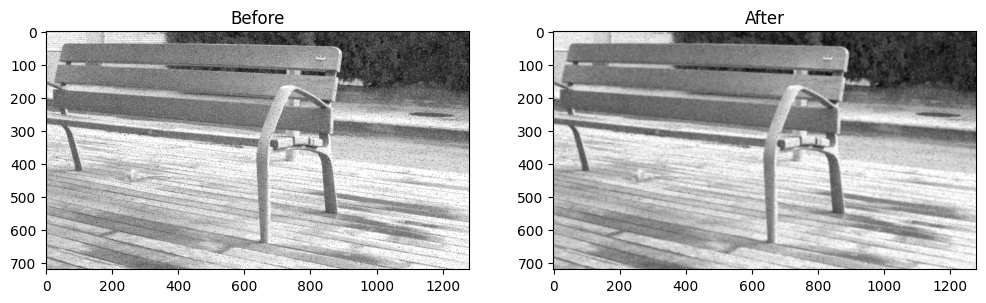

In [14]:
fs, pm = optimize_params(noise_img, clean_img, mean_filter)
print("Best filter size:", fs, "\nBest padding mode:", pm)
score = compare_ssim(clean_img, mean_blur, data_range=clean_img.max() - clean_img.min())
print("Best SSIM score when apply mean filter is:", score)
mean_blur = mean_filter(noise_img, fs, pm)
show_res(noise_img, mean_blur)

Best filter size: 3 
Best padding mode: replicate
Best SSIM score when apply median filter is: 0.9628636170478749


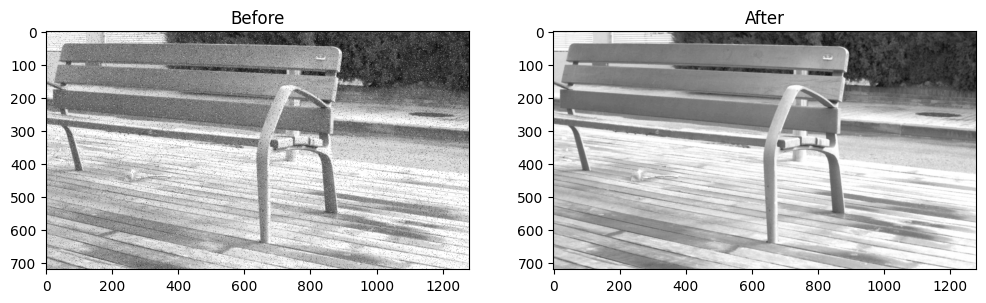

In [15]:
fs, pm = optimize_params(noise_img, clean_img, median_filter)
print("Best filter size:", fs, "\nBest padding mode:", pm)
score = compare_ssim(clean_img, median_blur, data_range=clean_img.max() - clean_img.min())
print("Best SSIM score when apply median filter is:", score)
median_blur = median_filter(noise_img, fs, pm)
show_res(noise_img, median_blur)

## 2. Unsharp mask filter

In [16]:
clean_img_path = "/content/drive/MyDrive/Colab/ori_img.png"

In [17]:
def gaussian_filter(img, filter_size=3, padding_mode='mirror'):
  """
    Smoothing image with mean gaussian filter with the size of filter_size.
    WARNING: Do not use the exterior functions from available libraries such as OpenCV, scikit-image, etc. Just do from scratch using function from the numpy library or functions in pure Python.

    Inputs:
      img: cv2 image: original image
      filter_size: int: size of square filter,
      padding_mode: str: 'zero'| 'mirror' | 'replicate'
    Return:
      smoothed_img: cv2 image: the smoothed image with gaussian filter.
  """
  def make_kernel(shape=(filter_size, filter_size), sigma=1.0):
    m, n = shape
    assert m % 2 == 1 and n %2 == 1, "Kernel shape must be odd"
    v = list(range(-(m // 2), (m + 1) // 2, 1))
    h = list(range(-(n // 2), (n + 1) // 2, 1))
    kernel = np.zeros(shape)
    for i in range(m):
        for j in range(n):
            kernel[i, j] = (1 / (2*np.pi*sigma**2)) * np.exp(-(v[i]**2 + h[j]**2) / (2*sigma**2))
    ratio =  np.sum(kernel)
    kernel = kernel / ratio
    return kernel

  kernel = make_kernel()
  s = filter_size // 2
  convolve = np.zeros(img.shape)
  img = padding_img(img, filter_size, padding_mode)
  x, y = img.shape
  for v in range(s, x - s):
    for h in range(s, y - s):  #
        area = img[(v - s):(v + s + 1), (h - s): (h + s + 1)]
        convolve[v - s, h - s] = np.sum(np.multiply(kernel, area))
  return convolve

def unsharp_filter(img, alpha, filter_type="gaussian", padding_mode="mirror", filter_size=3):
  """
    Unsharp mask filter
    Inputs:
      img: cv2 image: original image
      alpha: float: [0, 1]
      filter_type: str: 'gaussian'|'mean'|'median'
      filter_size: int: size of square filter,
      padding_mode: str: 'zero'| 'mirror' | 'replicate'
    Return:
      unsharped_img: cv2 image: the smoothed image with gaussian filter.
  """
  filter_func = gaussian_filter if filter_type=="gaussian" else median_filter if filter_type=="median" else mean_filter
  unsharped_img = img + alpha * (img - filter_func(img, filter_size, padding_mode))
  return unsharped_img


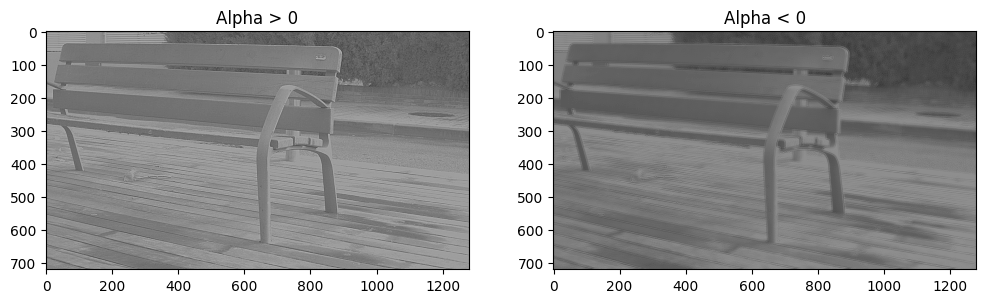

In [18]:
show_res(unsharp_filter(clean_img, 10), unsharp_filter(clean_img, -10), "Alpha > 0", "Alpha < 0")

## 3. Edge detection

In [14]:
import cv2
noise_img_path = "/content/drive/MyDrive/Colab/noise.png"
edge_img_path = "/content/drive/MyDrive/Colab/gt_edge.png"
noise_img = read_img(noise_img_path)
edge_img = read_img(edge_img_path)

[[241 242 243 ...  64  63  69]
 [251 251 251 ...  65   0  73]
 [254 254 254 ...  68  70  77]
 ...
 [178 179 178 ... 240 240 240]
 [176 177 178 ... 242 241 241]
 [170 172 174 ... 247 243 243]]


SSIM: 0.654388239671295


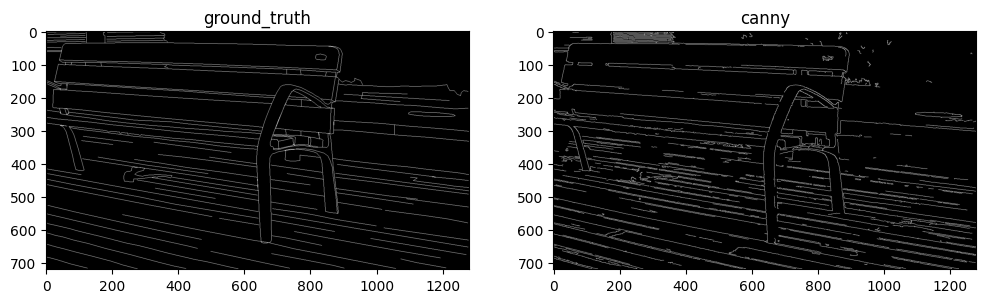

In [20]:
t_lower = 100
t_upper = 200
median_blur = median_filter(noise_img, filter_size=3, padding_mode="replicate")
median_blur = np.uint8(median_blur)
canny_edge = cv2.Canny(median_blur, t_lower, t_upper)
print("SSIM:", compare_ssim(edge_img, canny_edge, data_range=edge_img.max() - edge_img.min()))
show_res(edge_img, canny_edge, "ground_truth", "canny")

In [21]:
median_blur = median_filter(noise_img, filter_size=3, padding_mode="replicate")
median_blur = np.uint8(median_blur)
for upper in range(200, 256, 5):
  canny_edge = cv2.Canny(median_blur, 180, upper)
  print(f"SSIM if upper threshold is {upper}:", compare_ssim(edge_img, canny_edge, data_range=edge_img.max() - edge_img.min()))


SSIM if upper threshold is 200: 0.6844251790696576
SSIM if upper threshold is 205: 0.6868679895697899
SSIM if upper threshold is 210: 0.6901674380286822
SSIM if upper threshold is 215: 0.6919117211416093
SSIM if upper threshold is 220: 0.6940049104000199
SSIM if upper threshold is 225: 0.6949816002275071
SSIM if upper threshold is 230: 0.6970390003464227
SSIM if upper threshold is 235: 0.6977536369654955
SSIM if upper threshold is 240: 0.6991816556549182
SSIM if upper threshold is 245: 0.7002639450130395
SSIM if upper threshold is 250: 0.7019324689508859
SSIM if upper threshold is 255: 0.7025377539147916


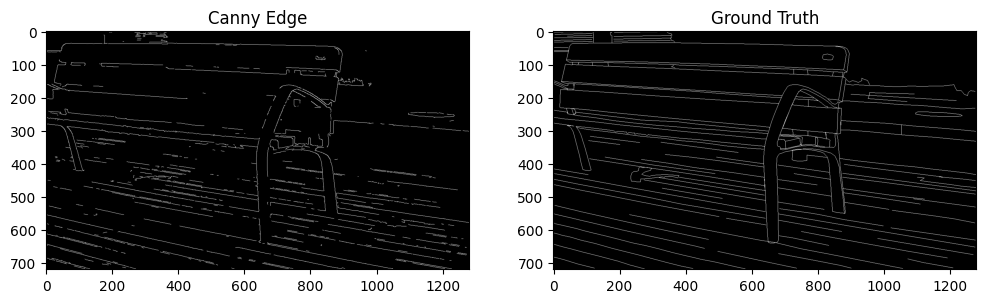

In [22]:
median_blur = median_filter(noise_img, filter_size=3, padding_mode="replicate")
median_blur = np.uint8(median_blur)
canny_edge = cv2.Canny(median_blur, 180, 255)
show_res(canny_edge, edge_img, "Canny Edge", "Ground Truth")


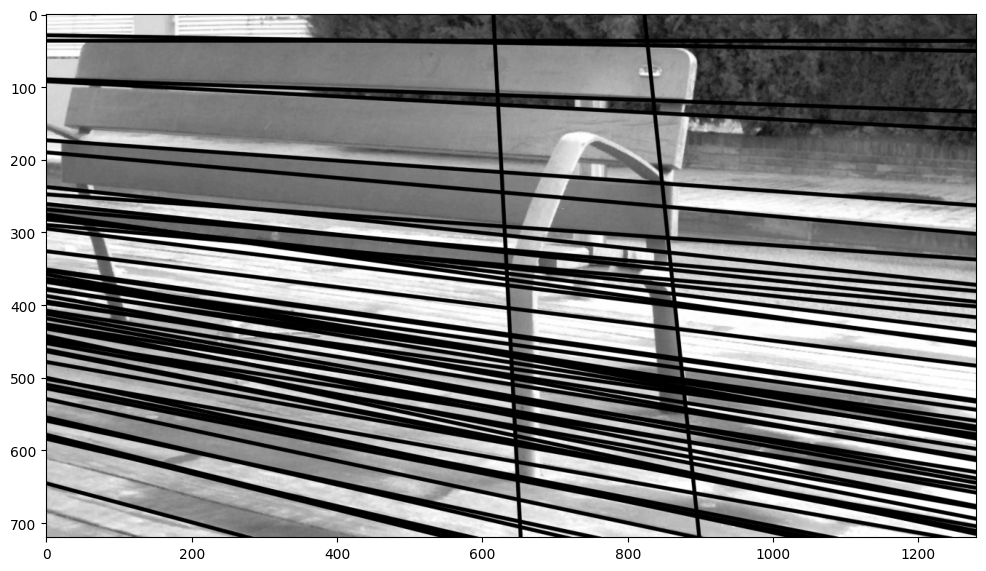

In [23]:
median_blur_copy = median_blur.copy()
lines = cv2.HoughLines(canny_edge, 1, np.pi / 180, 120, None, 0, 0)
if lines is not None:
  for i in range(0, len(lines)):
      rho = lines[i][0][0]
      theta = lines[i][0][1]
      a = math.cos(theta)
      b = math.sin(theta)
      x0 = a * rho
      y0 = b * rho
      pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
      pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
      cv2.line(median_blur_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
show_img(median_blur_copy)

In [33]:
median_blur = median_filter(noise_img, filter_size=3, padding_mode="replicate")
median_blur = np.uint8(median_blur)
lower = 100
upper = 200
delta = 5
alpha = 10000
while True:
  print(lower, upper)
  old_lower = lower
  old_upper = upper
  old_score = compare_ssim(edge_img, cv2.Canny(median_blur, lower, upper), data_range=edge_img.max() - edge_img.min())

  new_score_lower = compare_ssim(edge_img, cv2.Canny(median_blur, lower + delta, upper), data_range=edge_img.max() - edge_img.min())
  d_lower = (new_score_lower - old_score) / delta
  lower = lower + int(alpha * d_lower)

  new_score_upper = compare_ssim(edge_img, cv2.Canny(median_blur, lower, upper + delta), data_range=edge_img.max() - edge_img.min())
  d_upper = (new_score_upper - old_score) / delta
  upper = upper + int(alpha * d_upper)
  if old_lower == lower and old_upper == upper:
    print("Result", lower, upper)
    break




100 200
104 206
107 218
111 224
116 234
118 240
120 244
122 248
125 251
128 254
129 260
131 262
133 263
137 265
141 270
142 272
143 272
146 273
149 275
151 279
153 283
155 283
157 283
159 283
161 283
162 283
Result 162 283


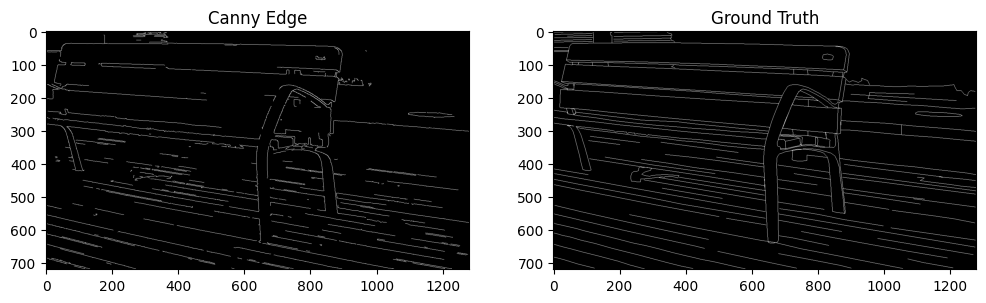

SSIM: 0.707793095992449


In [34]:
median_blur = median_filter(noise_img, filter_size=3, padding_mode="replicate")
median_blur = np.uint8(median_blur)
canny_edge = cv2.Canny(median_blur, 162, 283)
show_res(canny_edge, edge_img, "Canny Edge", "Ground Truth")
print("SSIM:", compare_ssim(edge_img, canny_edge, data_range=edge_img.max() - edge_img.min()))